<a href="https://colab.research.google.com/drive/1mAIjIW2SgHqdoSxd_DHPvTaqNikSeOv6?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

# Sales Forecasting Experiment

This notebook contains implementation and experimentation of different time series forecasting models for forecasting daily sales of an online retailer.

# Install Libraries

In [1]:
!pip install pmdarima darts lightgbm prophet wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 760.5/760.5 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.4/153.4 kB 14.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.9/110.9 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 725.0/725.0 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.8/218.8 kB 21.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Import Libraries

In [2]:
from abc import ABC, abstractmethod
from typing import Union, Tuple
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import lightgbm as lgb
import joblib
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import timedelta
import pmdarima as pm
from prophet import Prophet
import prophet
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from darts.models import RNNModel
from darts.timeseries import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.utils.statistics import check_seasonality
from statsmodels.tsa.seasonal import seasonal_decompose
import wandb

In [3]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Utilities

In [4]:
def plot_train_test(train_data: pd.DataFrame, test_data:pd.DataFrame, predictions: pd.Series, title='Train, Test, and Predictions'):
    """
    Plot the training, testing, and predicted data.

    Parameters:
    - train_data (pd.DataFrame): DataFrame containing the training data
    - test_data (pd.DataFrame): DataFrame containing the test data
    - predictions (pd.Series): Series containing the predicted data
    - title (str): The title of the plot
    """

    plt.figure(figsize=(15, 6))
    plt.plot(train_data.index, train_data['Sales'], label='Train')
    plt.plot(test_data.index, test_data['Sales'], label='Test')
    plt.plot(test_data.index, predictions, label='Predictions')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.show()

def plot_forecast(original_data: pd.DataFrame, forecast_data: pd.DataFrame, title='Forecast'):
    """
    Plot the forecasted data along with the original data.

    Parameters:
    - original_data (pd.DataFrame): DataFrame containing the original data
    - forecast_data (pd.DataFrame): DataFrame containing the forecasted data
    - title (str): The title of the plot
    """
    plt.figure(figsize=(15, 6))
    plt.plot(original_data.index, original_data['Sales'], label='Original Data')
    plt.plot(forecast_data.index, forecast_data['Predicted Sales'], label='Forecast')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.show()

# Data Processor

In [5]:
class DataProcessor:
    def __init__(self, config):
        """
        Initialize the DataProcessor with a file path to load the data from.
        """
        try:
          self.config = config
          self.file_path = self.config["file_path"]
        except Exception as e:
          print(f"Provide a file path for data : {e}")

        # Changed from Excel to CSV as it takes longer time to load the dataset.
        self.data = pd.read_csv(self.file_path)

    def preprocess_data(self):
        """
        Perform basic preprocessing on the data.
        """
        self.data['InvoiceDate'] = pd.to_datetime(self.data['InvoiceDate'])
        self.data['Sales'] = self.data['Quantity'] * self.data['UnitPrice']

        # Resampling to daily sales and filling any missing values with 0 as we have to predict sales for each day in future
        daily_sales = self.data.resample('D', on='InvoiceDate').agg({'Sales': 'sum'})
        daily_sales.replace(0, method='ffill', inplace=True)
        # Resample to get daily total quantity
        daily_quantity = self.data.resample('D', on='InvoiceDate').agg({'Quantity': 'sum'})
        daily_quantity.replace(0, method='ffill', inplace=True)
        # Combine daily_sales and daily_quantity into a single DataFrame
        daily_series_data = pd.concat([daily_sales, daily_quantity], axis=1)

        return daily_series_data

In [6]:
data_config = {
    "file_path":"/content/drive/MyDrive/Sales Data/Online_Retail.csv",
}

data_processor = DataProcessor(data_config)
daily_sales_data = data_processor.preprocess_data()

<Axes: xlabel='InvoiceDate'>

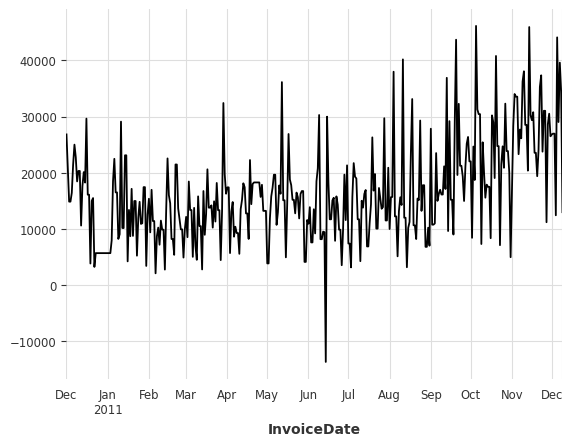

In [7]:
daily_sales_data['Quantity'].plot()

<Axes: xlabel='InvoiceDate'>

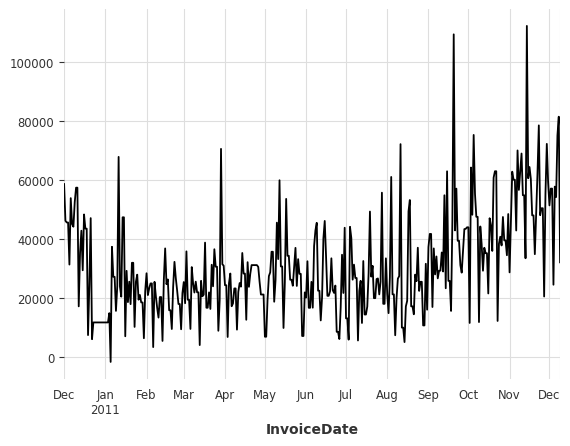

In [8]:
daily_sales_data['Sales'].plot()

In [9]:
daily_sales_series = TimeSeries.from_dataframe(daily_sales_data, value_cols=['Sales'])

# Check seasonality in the dataset for further processing via ACF

ALPHA = 0.05

for m in range(2, 25):
    is_seasonal, mseas = check_seasonality(daily_sales_series, m=m, alpha=ALPHA)
    if is_seasonal:
        break

print("seasonal : " + str(is_seasonal))
if is_seasonal:
    print('There is seasonality of order {}.'.format(mseas))

seasonal : True
There is seasonality of order 5.


# Model Class Definition

In [10]:
class ForecastModel(ABC):
    def __init__(self, config: dict):
        """Initialize the ForecastModel object with empty data and model attributes."""
        self.config = config
        self.test_size = self.config.get('test_size', 30)
        try:
          self.data = self.config['data'].copy()
        except Exception as e:
          print(f"Error loading data: {e}")

    def split_data(self):
        """Splits the data into training and test sets based on the `test_size` attribute."""
        try:
          self.train_data = self.data.iloc[:-self.test_size]
          self.test_data = self.data.iloc[-self.test_size:]
        except Exception as e:
          print(f"Error during data split: {e}")

    def get_features(self) -> None:
        """Sets the features for model training."""
        self.features = self.data

    @abstractmethod
    def train(self) -> None:
        """Abstract method to train the model."""
        pass

    @abstractmethod
    def predict(self, test_set: pd.DataFrame) -> pd.Series:
        """Abstract method to make predictions on a given test set.

        Args:
            test_set (pd.DataFrame): DataFrame containing the test data.

        Returns:
            pd.Series: Series containing the predictions.
        """
        pass

    def get_forecast_dates(self, start_date: str = '2011-12-09', end_date: str = '2012-12-31') -> list:
        """Generates a list of dates for forecasting between `start_date` and `end_date`.

        Args:
            start_date (str): Start date for forecasting.
            end_date (str): End date for forecasting.

        Returns:
            list: List of dates for forecasting.
        """
        start_date = pd.Timestamp(start_date)
        end_date = pd.Timestamp(end_date)
        forecast_steps = (end_date - start_date).days
        forecast_dates = [start_date + timedelta(days=i) for i in range(1, forecast_steps+1)]
        return forecast_dates

    @abstractmethod
    def forecast(self, start_date: str = None, end_date: str = None) -> pd.DataFrame:
        """Abstract method to forecast data between `start_date` and `end_date`.

        Args:
            start_date (str): Start date for forecasting.
            end_date (str): End date for forecasting.

        Returns:
            pd.DataFrame: DataFrame containing the forecasted values.
        """
        pass

    def save_file(self, file_path: str) -> None:
      """
        Save the trained model to a file.

        Args:
            file_path (str): File path to save the model.
      """
      joblib.dump(self.model, file_path)

    def load_file(self, file_path: str) -> None:
      """
        Load a trained model from a file.

        Args:
            file_path (str): File path to load the model from.
      """
      self.model = joblib.load(file_path)

    def evaluate(self, true_values: pd.Series, predicted_values: pd.Series) -> dict:
        """Evaluates the model using RMSE, MAE, and MAPE metrics.

        Args:
            true_values (pd.Series): True values.
            predicted_values (pd.Series): Predicted values.

        Returns:
            dict: Dictionary containing RMSE, MAE, and MAPE metrics
        """
        return {
            'RMSE': np.sqrt(mean_squared_error(true_values, predicted_values)),
            'MAE': mean_absolute_error(true_values, predicted_values),
            'MAPE': mean_absolute_percentage_error(true_values, predicted_values)
        }


# LightGBM

In [44]:
class LightGBMModel(ForecastModel):
    def __init__(self, config):
        """
        Initialize the LightGBMModel with configuration parameters.

        Args:
            config (dict): Configuration dictionary containing:
                           - 'data': DataFrame with the time series data.
                           - 'lag_start': Start of the lag features (optional, default=1).
                           - 'lag_end': End of the lag features (optional, default=30).
                           - 'lgb_params': LightGBM parameters (optional).
                           - 'num_boost_round': Number of boosting rounds (optional, default=1000).
                           - 'test_size': Number of test samples (optional, default=30).
        """
        super().__init__(config)
        self.lag_start = config.get('lag_start', 1)
        self.lag_end = config.get('lag_end', 30)
        self.lgb_params = config.get('lgb_params', {
            'objective': 'regression',
            'metric': 'rmse',
            'boosting_type': 'gbdt',
            'num_leaves': 20,
            'learning_rate': 0.01,
            'feature_fraction': 0.9
        })
        self.num_boost_round = config.get('num_boost_round', 1000)
        self.test_size = config.get('test_size', 30)
        self.get_features()
        self.split_data()

    def get_features(self) -> None:
        """
        Generate lagged features based on the Sales column in the data.
        """
        data_lagged = self.data.copy()
        for i in range(self.lag_start, self.lag_end + 1):
            data_lagged[f"lag_{i}"] = data_lagged['Sales'].shift(i)
        self.features = data_lagged.dropna()

    def split_data(self):
        """
        Splits the feature data into training and test sets.
        """
        self.X_train = self.features.iloc[:-self.test_size].drop(['Sales'], axis=1)
        self.y_train = self.features.iloc[:-self.test_size]['Sales']
        self.X_test = self.features.iloc[-self.test_size:].drop(['Sales'], axis=1)
        self.y_test = self.features.iloc[-self.test_size:]['Sales']

    def train(self) -> None:
        """
        Train the LightGBM model on the training data.
        """
        lgb_train = lgb.Dataset(self.X_train, self.y_train)
        self.model = lgb.train(self.lgb_params, lgb_train, num_boost_round=self.num_boost_round)

    def predict(self) -> pd.Series:
        """
        Make predictions on the test set.

        Returns:
            pd.Series: Predicted values.
        """
        predictions = self.model.predict(self.X_test, num_iteration=self.model.best_iteration)
        return predictions

    def forecast(self, start_date: str = '2011-12-09', end_date: str = '2012-12-31') -> pd.DataFrame:
        """
        Generate forecasted values up to a specified end date.

        Args:
            end_date (str): The end date for the forecast.

        Returns:
            pd.DataFrame: DataFrame containing forecasted values.
        """
        forecasted_values = []
        current_data_lagged = self.features
        forecast_dates = self.get_forecast_dates(start_date=start_date, end_date=end_date)
        latest_data = current_data_lagged.iloc[-1].drop(['Sales'])

        # Forecast sales auto regressively by using latest forecast
        for date in range(len(forecast_dates)):
            prediction = self.model.predict(latest_data.values.reshape(1, -1), num_iteration=self.model.best_iteration)[0]
            forecasted_values.append(prediction)

            # Update lag features
            latest_data = latest_data.shift(-1)
            latest_data.iloc[-1] = prediction

        forecasted_values = pd.DataFrame({'Date': forecast_dates, 'Predicted Sales': forecasted_values})
        forecasted_values.set_index('Date', inplace=True)

        return forecasted_values

    def save_file(self, file_path: str = "lgm_model.pkl") -> None:
        """
        Save the trained model to a file.

        Args:
            file_path (str): File path to save the model.
        """
        self.model.save_model(file_path, num_iteration=self.model.best_iteration)

    def load_file(self, file_path: str) -> None:
        """
        Load a trained model from a file.

        Args:
            file_path (str): File path to load the model from.
        """
        self.model = lgb.Booster(model_file=file_path)


## Train

In [45]:
# Modify Parameters

lgm_run = 2

NUM_LEAVES = 12
LGM_LR = 0.001
FEATURE_FRAC = 0.9

# Create a configuration dictionary
lgm_config = {
    'data': daily_sales_data,
    'lag_start': 1,
    'lag_end': 5,
    'lgb_params': {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'num_leaves': NUM_LEAVES,
        'learning_rate': LGM_LR,
        'feature_fraction': FEATURE_FRAC
    },
    'num_boost_round': 1000,
    'test_size': 30
}

run = wandb.init(
    project = "lightgbm_sales_forecast",
    config = lgm_config,
    name = f"run-{lgm_run}"
)

In [46]:
# Initialize the model with the configuration
lgm_forcaster = LightGBMModel(lgm_config)

# Train the model
lgm_forcaster.train()

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 684
[LightGBM] [Info] Number of data points in the train set: 339, number of used features: 6
[LightGBM] [Info] Start training from score 28536.796390


## Evaluate

{'RMSE': 19245.462037424433, 'MAE': 14722.485743123576, 'MAPE': 0.23496187902061216}


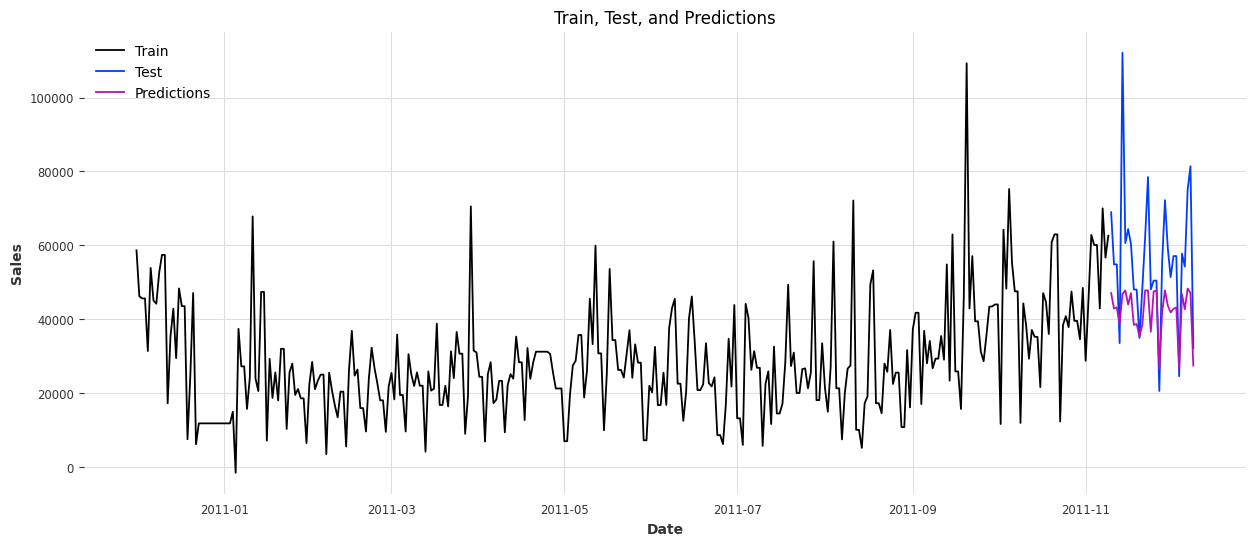

MAE,▁
MAPE,▁
RMSE,▁
MAE,14722.48574
MAPE,0.23496
RMSE,19245.46204


In [47]:
# Make predictions
lgm_predictions = lgm_forcaster.predict()

#Evaluation
lgm_eval = lgm_forcaster.evaluate(lgm_forcaster.y_test, lgm_predictions)
wandb.log(lgm_eval)
print(lgm_eval)

# Plot the train, test, pred graph
plot_train_test(daily_sales_data[:-lgm_forcaster.test_size],daily_sales_data[-lgm_forcaster.test_size:], lgm_predictions)
wandb.finish()

## Forecast

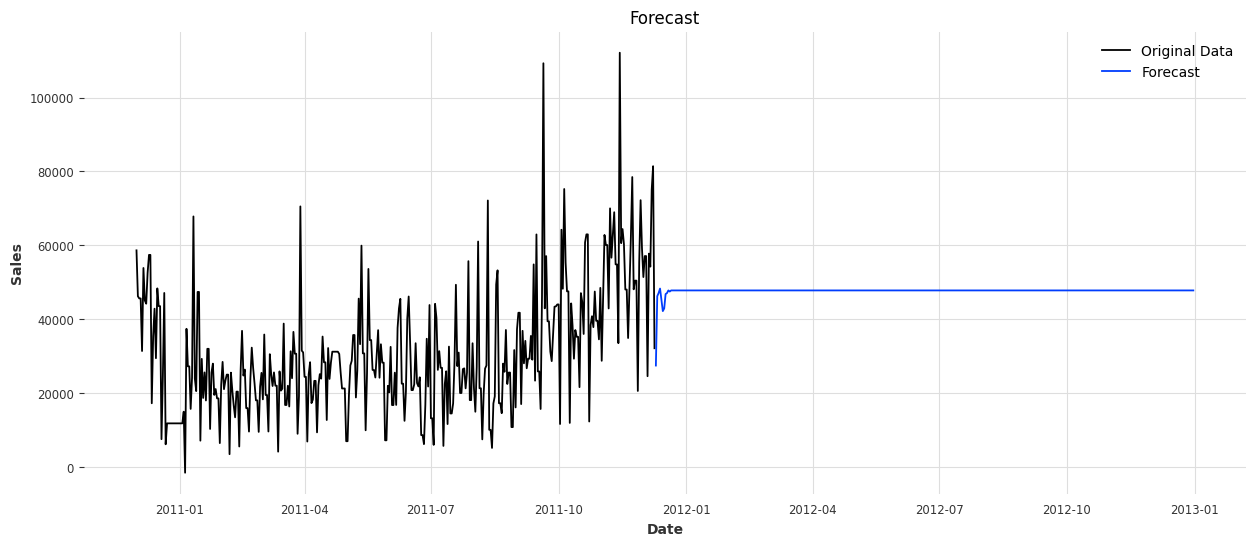

In [48]:
lgm_forecasted_values = lgm_forcaster.forecast()
plot_forecast(daily_sales_data, lgm_forecasted_values)

# Auto ARIMA

In [23]:
class AutoARIMAModel(ForecastModel):
    def __init__(self, config):
      """
        Initialize the LightGBMModel with configuration parameters.

        Args:
            config (dict): Configuration dictionary containing:
                           - 'data': DataFrame with the time series data.
                           - 'arima_params': Auto ARIMA parameters (optional).
                           - 'test_size': Number of test samples (optional, default=30).
      """
      super().__init__(config)
      self.arima_params = config.get('arima_params', {
          'start_p': 0,
          'start_q': 0,
          'max_p': 5,
          'max_q': 5,
          'm': 7,
          'start_P': 0,
          'seasonal': True,
          'd': 0,
          'D': 1,
          'trace': True,
          'error_action': 'ignore',
          'suppress_warnings': True,
          'stepwise': True
      })

    def train(self) -> None:
      """
        Train the Auto ARIMA model on the training data.
      """
      self.split_data()
      self.model = pm.auto_arima(self.train_data, **self.arima_params)

    def predict(self) -> pd.Series:
      """
        Make predictions on the test set.

        Returns:
            pd.Series: Predicted values.
      """
      predictions = self.model.predict(n_periods=len(self.test_data), return_conf_int=False)
      return predictions

    def forecast(self, start_date: str = '2011-12-09', end_date: str = '2012-12-31') -> pd.DataFrame:
      """
        Generate forecasted values up to a specified end date.

        Args:
            end_date (str): The end date for the forecast.

        Returns:
            pd.DataFrame: DataFrame containing forecasted values.
      """
      forecast_dates = self.get_forecast_dates(start_date=start_date, end_date=end_date)
      forecasted_values = self.model.predict(n_periods=len(forecast_dates))
      forecasted_values = pd.DataFrame({'Date': forecast_dates, 'Predicted Sales': forecasted_values}).set_index('Date')
      return forecasted_values



## Train

In [24]:
# Modify Parameters
arima_run = 2

M = 14
START_P = 0
START_Q = 0
MAX_P = 5
MAX_Q = 5
d = 0
D = 1
SEASONAL = True
STEPWISE = True

# Create a configuration dictionary
auto_arima_config = {
    'data': daily_sales_data[['Sales']],
    'test_size': 30,
    'arima_params': {
        'start_p': START_P,
        'start_q': START_Q,
        'max_p': MAX_P,
        'max_q': MAX_Q,
        'm': M,
        'start_P': 0,
        'seasonal': SEASONAL,
        'd': d,
        'D': D,
        'trace': True,
        'error_action': 'ignore',
        'suppress_warnings': True,
        'stepwise': STEPWISE
    }
}

run = wandb.init(
    settings=wandb.Settings(start_method="thread"),
    project = "auto_arima_forecast",
    name = f"run-{arima_run}",
    config = auto_arima_config['arima_params']
)

In [25]:
# Initialize the model with the configuration
auto_arima_forecaster = AutoARIMAModel(auto_arima_config)

# Train the model
auto_arima_forecaster.train()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[14] intercept   : AIC=7221.946, Time=0.68 sec
 ARIMA(0,0,0)(0,1,0)[14] intercept   : AIC=7345.241, Time=0.06 sec
 ARIMA(1,0,0)(1,1,0)[14] intercept   : AIC=7237.626, Time=0.51 sec
 ARIMA(0,0,1)(0,1,1)[14] intercept   : AIC=7204.488, Time=0.63 sec
 ARIMA(0,0,0)(0,1,0)[14]             : AIC=7343.578, Time=0.06 sec
 ARIMA(0,0,1)(0,1,0)[14] intercept   : AIC=7331.221, Time=0.16 sec
 ARIMA(0,0,1)(1,1,1)[14] intercept   : AIC=7206.408, Time=0.96 sec
 ARIMA(0,0,1)(0,1,2)[14] intercept   : AIC=7206.290, Time=1.49 sec
 ARIMA(0,0,1)(1,1,0)[14] intercept   : AIC=7244.658, Time=0.45 sec
 ARIMA(0,0,1)(1,1,2)[14] intercept   : AIC=inf, Time=6.72 sec
 ARIMA(1,0,1)(0,1,1)[14] intercept   : AIC=7181.989, Time=1.75 sec
 ARIMA(1,0,1)(0,1,0)[14] intercept   : AIC=7316.094, Time=0.58 sec
 ARIMA(1,0,1)(1,1,1)[14] intercept   : AIC=7183.985, Time=2.16 sec
 ARIMA(1,0,1)(0,1,2)[14] intercept   : AIC=7183.988, Time=2.55 sec
 ARIMA(1,0,1)(1,1,0)[14]

## Evaluate

{'RMSE': 17767.367011599177, 'MAE': 12741.600440188711, 'MAPE': 0.2095427428335332}


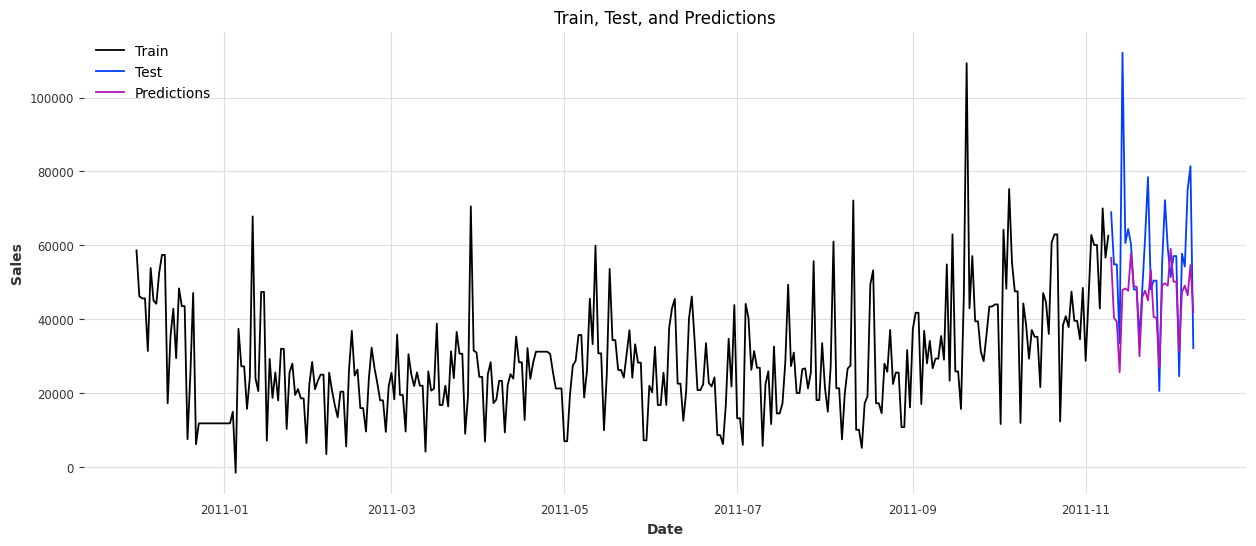

MAE,▁
MAPE,▁
RMSE,▁
MAE,12741.60044
MAPE,0.20954
RMSE,17767.36701


In [26]:
# Make predictions
auto_arima_predictions = auto_arima_forecaster.predict()

#Evaluation
auto_arima_eval = auto_arima_forecaster.evaluate(auto_arima_forecaster.test_data['Sales'], auto_arima_predictions)
wandb.log(auto_arima_eval)
print(auto_arima_eval)

# Plot the train, test, pred graph
plot_train_test(auto_arima_forecaster.train_data,auto_arima_forecaster.test_data, auto_arima_predictions)
wandb.finish()

## Forecast

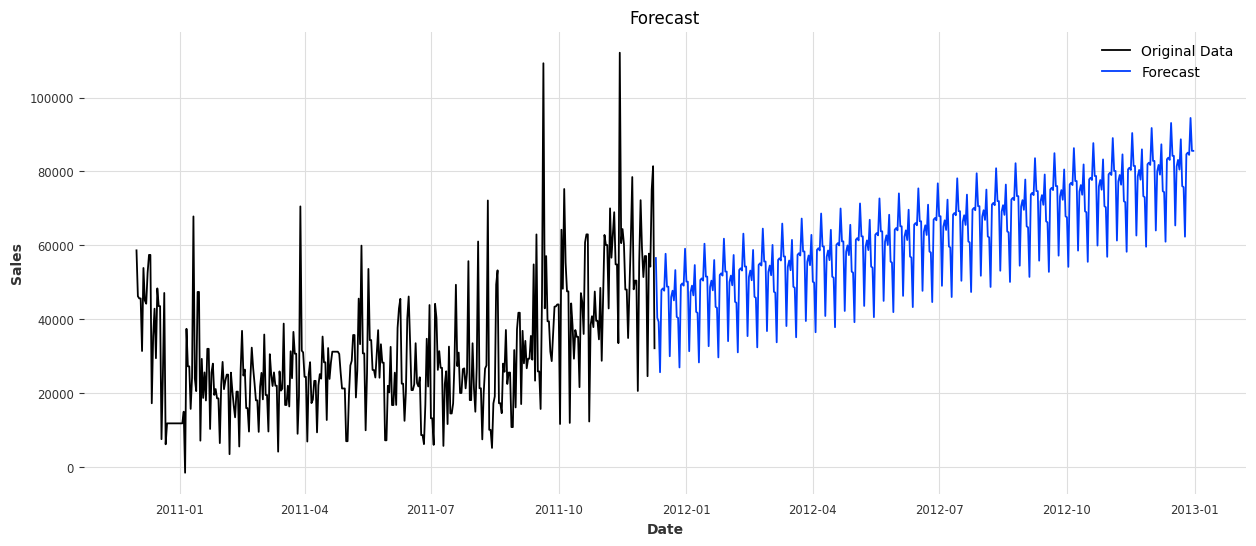

In [27]:
auto_arima_forecasted_values = auto_arima_forecaster.forecast()
plot_forecast(daily_sales_data, auto_arima_forecasted_values)

# SARIMAX

In [30]:
class SARIMAXModel(ForecastModel):
    def __init__(self, config):
      """
        Initialize the LightGBMModel with configuration parameters.

        Args:
            config (dict): Configuration dictionary containing:
                           - 'data': DataFrame with the time series data.
                           - 'order': model parameters for moving average, differencing and auto-regressive term (optional, (0, 0, 0))
                           - 'seasonal order': seasonality model parameters (optional, (1, 0, 1, 14)).
      """
      super().__init__(config)
      self.order = config.get('order', (0, 0, 0))
      self.seasonal_order = config.get('seasonal_order', (1, 0, 1, 14))

    def train(self) -> None:
      """
        Train the SARIMAX model on the training data.
      """
      self.split_data()
      self.model = SARIMAX(self.train_data, order=self.order, seasonal_order=self.seasonal_order)
      self.model = self.model.fit(disp=False)

    def predict(self) -> pd.Series:
      """
        Make predictions on the test set.

        Returns:
            pd.Series: Predicted values.
      """
      start = len(self.train_data)
      end = start + len(self.test_data) - 1
      predictions = self.model.predict(start=start, end=end, dynamic=False)
      return predictions

    def forecast(self, start_date: str = '2011-12-09', end_date: str = '2012-12-31') -> pd.DataFrame:
      """
        Generate forecasted values up to a specified end date.

        Args:
            end_date (str): The end date for the forecast.

        Returns:
            pd.DataFrame: DataFrame containing forecasted values.
      """
      forecast_dates = self.get_forecast_dates(start_date=start_date, end_date=end_date)
      forecasted_values = self.model.forecast(steps=len(forecast_dates))
      forecasted_values = pd.DataFrame({'Date': forecast_dates, 'Predicted Sales': forecasted_values}).set_index('Date')
      return forecasted_values


## Train

In [40]:

sarimax_run = 1
SARIMAX_ORDER=(1, 0, 1)
SARIMAX_SEASONAL_ORDER = (1, 0, 1, 14)

sarimax_config = {
    'data': daily_sales_data[['Sales']],
    'order': SARIMAX_ORDER,
    'seasonal_order': SARIMAX_SEASONAL_ORDER,
    'test_size': 30
}

wandb.init(
    project = "sarimax_forecast",
    name = f"run-{sarimax_run}",
    config ={
        'order' : sarimax_config['order'],
        'seasonal_order': sarimax_config['seasonal_order']
    }
)



In [41]:
# Initialize the SARIMAX model
sarimx_forecaster = SARIMAXModel(sarimax_config)

# Train the model
sarimx_forecaster.train()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


## Evaluate

{'RMSE': 15269.741812714165, 'MAE': 10122.86174789606, 'MAPE': 0.19637728723747847}


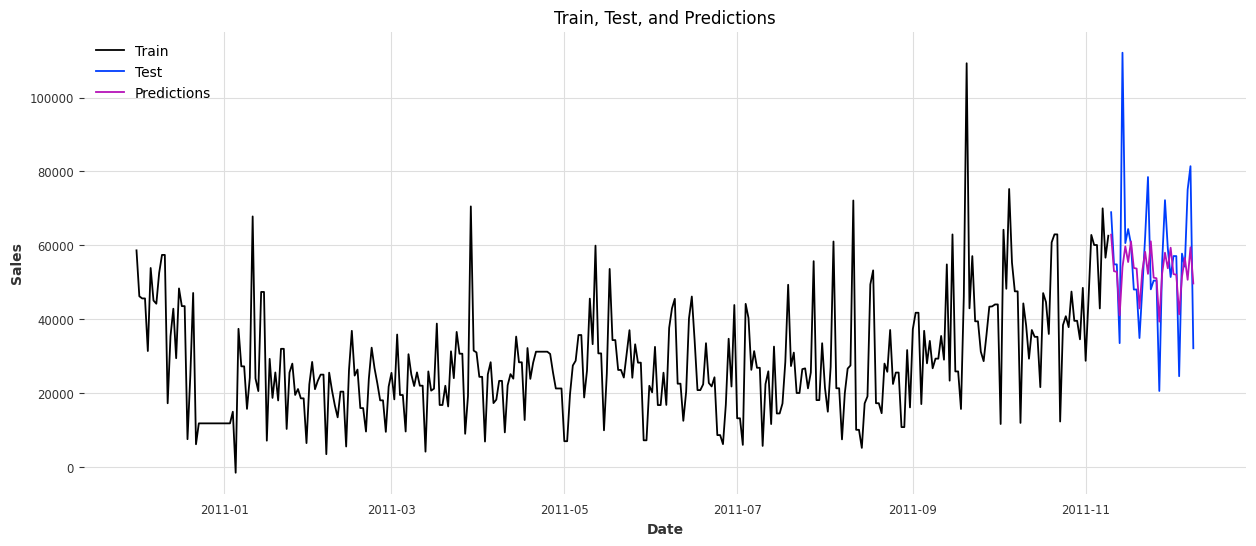

MAE,▁
MAPE,▁
RMSE,▁
MAE,10122.86175
MAPE,0.19638
RMSE,15269.74181


In [42]:
# Make predictions
sarimax_predictions = sarimx_forecaster.predict()

#Evaluation
sarimx_eval = sarimx_forecaster.evaluate(sarimx_forecaster.test_data['Sales'], sarimax_predictions)
wandb.log(sarimx_eval)
print(sarimx_eval)

# Plot the train, test, pred graph
plot_train_test(sarimx_forecaster.train_data, sarimx_forecaster.test_data, sarimax_predictions)
wandb.finish()

## Forecast

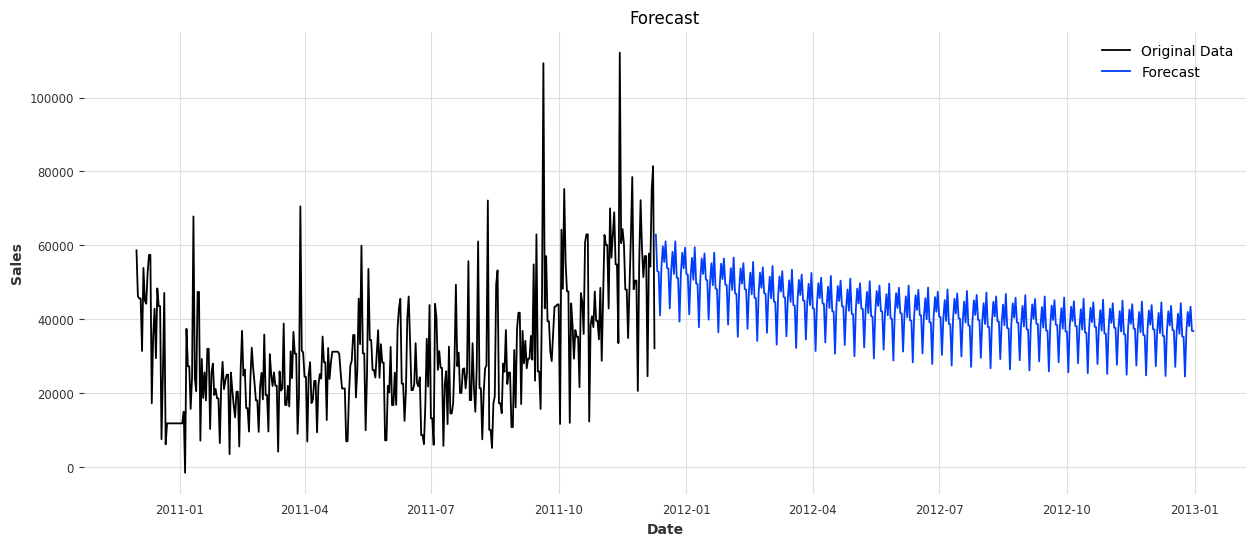

In [43]:
sarimx_forecasted_values = sarimx_forecaster.forecast()
plot_forecast(daily_sales_data, sarimx_forecasted_values)

# Prophet

In [11]:
class ProphetModel(ForecastModel):
    def __init__(self, config):
        """
        Initialize the ProphetModel with configuration parameters.

        Args:
            config (dict): Configuration dictionary containing:
                           - 'data' : Data used for training and forecasting
                           - 'prophet_params': Parameters for the Prophet model (optional).
                           - 'additional_seasonality': Additional seasonal components (optional).
                           - 'test_size': The test size to split the data for evaluation.
                           - 'use_UK_holidays': A bool value whether to incorporate UK holidays (optional, False)
        """
        super().__init__(config)
        self.data = self.data.reset_index().rename(columns={'InvoiceDate': 'ds', 'Sales': 'y'})
        self.prophet_params = config.get('prophet_params', {
            'yearly_seasonality': True,
            'weekly_seasonality': True,
            'daily_seasonality': False,
            'seasonality_mode': 'additive',
            'uncertainty_samples': 100
        })
        self.additional_seasonality = config.get('additional_seasonality', {
            'name': 'biweekly',
            'period': 14,
            'fourier_order': 5
        })

        # Initialize Prophet model
        self.model = Prophet(**self.prophet_params)
        self.model.add_seasonality(**self.additional_seasonality)
        if self.config.get('use_UK_holidays', False):
          self.model.add_country_holidays(country_name='UK')

    def train(self) -> None:
        """
        Train the Prophet model on the training data.
        """
        self.split_data()
        self.model.fit(self.train_data[['ds', 'y']])

    def predict(self) -> pd.Series:
        """
        Make predictions on the test set.

        Returns:
            pd.Series: Predicted values.
        """
        future = self.model.make_future_dataframe(periods=len(self.test_data))
        forecast = self.model.predict(future)
        predictions = forecast.tail(len(self.test_data))['yhat']
        return pd.Series(predictions.values, index=self.test_data.ds)

    def forecast(self, start_date: str = '2011-12-09', end_date: str = '2012-12-31') -> pd.DataFrame:
        """
        Generate forecasted values from a start date to a specified end date.

        Args:
            start_date (str): The start date for the forecast.
            end_date (str): The end date for the forecast.

        Returns:
            pd.DataFrame: DataFrame containing forecasted values.
        """
        forecast_dates = self.get_forecast_dates(start_date=start_date, end_date=end_date)
        future = self.model.make_future_dataframe(periods=len(forecast_dates))
        future_forecast = self.model.predict(future)
        forecasted_values = future_forecast.tail(len(forecast_dates))
        forecasted_values['ds'] = forecast_dates
        forecasted_values = forecasted_values.rename(columns={'ds': 'Date', 'yhat': 'Predicted Sales'}).set_index('Date')
        return forecasted_values


## Train

In [33]:
# Modify parameters
prophet_run = 8

YEAR_SEAS = True
WEEK_SEAS = True
DAILY_SEAS = True
SEAS_MODE = 'additive'
UNCERTAIN_EX = 100
ADDT_SEAS = 'biweekly'
PERIOD = 14
HOLIDAYS = False


# Create a configuration dictionary
prophet_config = {
    'data': daily_sales_data,
    'prophet_params': {
        'yearly_seasonality': YEAR_SEAS,
        'weekly_seasonality': WEEK_SEAS,
        'daily_seasonality': DAILY_SEAS,
        'seasonality_mode': SEAS_MODE,
        'uncertainty_samples': UNCERTAIN_EX,
    },
    'additional_seasonality': {
        'name': ADDT_SEAS,
        'period': PERIOD,
        'fourier_order': 5
    },
    'test_size': 30,
    'use_UK_holidays': HOLIDAYS,
}


wandb.init(
    project="prophet_forecast",
    name=f'run-{prophet_run}',
    config={
        'prophet_params': prophet_config['prophet_params'],
        'additional_seasonality': prophet_config['additional_seasonality']
    }
)


In [34]:
# Initialize the model with the configuration
prophet_forecaster = ProphetModel(prophet_config)

# Train the model
prophet_forecaster.train()

DEBUG:cmdstanpy:input tempfile: /tmp/tmpnz3v1yub/x89zem3n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnz3v1yub/m7oaehns.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25275', 'data', 'file=/tmp/tmpnz3v1yub/x89zem3n.json', 'init=/tmp/tmpnz3v1yub/m7oaehns.json', 'output', 'file=/tmp/tmpnz3v1yub/prophet_model6e66yzfk/prophet_model-20230829201136.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:11:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:11:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


## Evaluate

{'RMSE': 15520.030234441318, 'MAE': 10769.904310367554, 'MAPE': 0.22379257933882032}


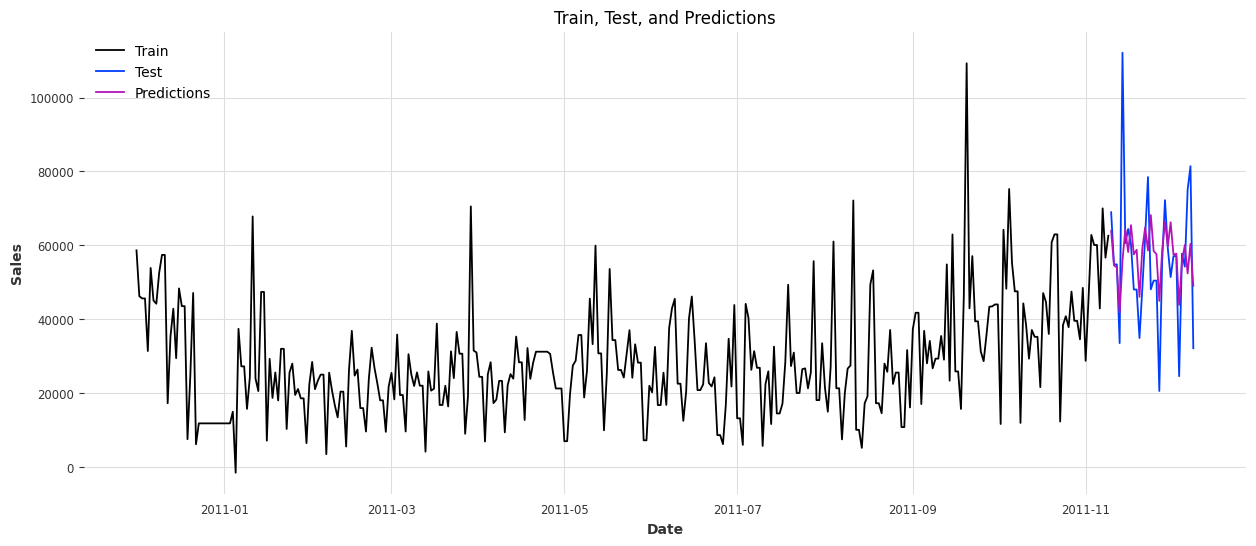

MAE,▁
MAPE,▁
RMSE,▁
MAE,10769.90431
MAPE,0.22379
RMSE,15520.03023


In [35]:
# Make predictions
prophet_predictions = prophet_forecaster.predict()

#Evaluation
prophet_eval = prophet_forecaster.evaluate(daily_sales_data[-prophet_forecaster.test_size:]['Sales'], prophet_predictions)
wandb.log(prophet_eval)
print(prophet_eval)

# Plot the train, test, pred graph
plot_train_test(daily_sales_data[:-prophet_forecaster.test_size],daily_sales_data[-prophet_forecaster.test_size:], prophet_predictions)
wandb.finish()

## Forecast

<ipython-input-11-7a211a8eece5>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecasted_values['ds'] = forecast_dates


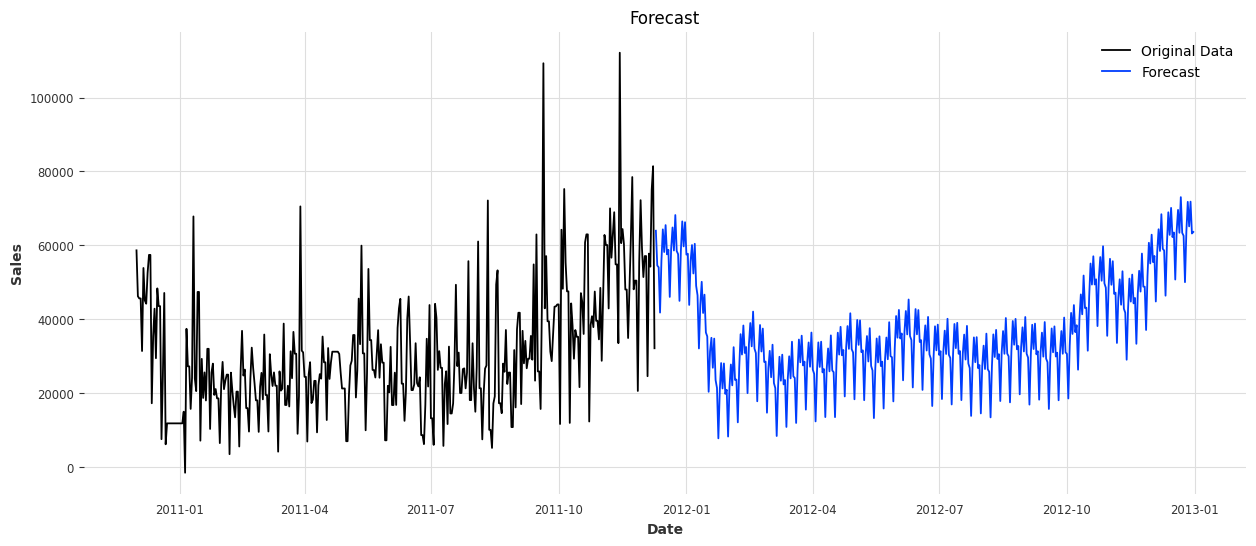

In [36]:
prophet_forecasted_values = prophet_forecaster.forecast()
plot_forecast(daily_sales_data, prophet_forecasted_values)

In [37]:
previous_sales = daily_sales_data['Sales'].sum()
fcst_sales = prophet_forecasted_values['Predicted Sales'].sum()

print(f"Total Sales 2010-11 : {previous_sales:.2f}")
print(f"Total Sales 2011-12 : {fcst_sales:.2f}")

Total Sales 2010-11 : 11578222.57
Total Sales 2011-12 : 14313040.27


## Analysis

In [38]:
prophet_2012_forecast_df = prophet_forecasted_values[['Predicted Sales','yhat_lower','yhat_upper']]
prophet_2012_forecast_df.to_csv(f'prophet_2012_{SEAS_MODE}_forecast.csv', index=True)

In [ ]:
'''
To Do: For interpretation of the results, we can do the following:
1. Analyse the daily, weekly and monthly sales pattern and compare with previous year.
2. Analyse the weekday and weekend sales pattern and compare with previous year.
3. Do the trend, seasonality and residual analysis and compare with previous year.
'''

# RNN Model

In [80]:
class RecurrentNNModel(ForecastModel):
    def __init__(self, config):
        """
        Initialize the RecurrentNNModel with configuration parameters.

        Args:
            config (dict): Configuration dictionary containing:
                           - 'data': DataFrame with the time series data.
                           - 'test_size': Number of test samples (optional, default=30).
                           - 'model_params': RNN model parameters (optional).
                           - 'scaler': Scaler for data normalization (optional).
        """
        super().__init__(config)
        self.ds_series = TimeSeries.from_dataframe(self.data, value_cols=['Sales'])

        # Normalization
        self.normalize_data()

        # Data split
        self.split_data()

        # Model configuration
        self.model_params = config.get('model_params', {
            'model': "LSTM",
            'hidden_dim': 20,
            'batch_size': 16,
            'n_epochs': 50,
            'random_state': 42,
            'training_length': 24,
            'input_chunk_length': 16,
            'force_reset': True,
            'model_name': "daily_sales_RNN",
            'save_checkpoints': True,
            'n_rnn_layers': 1
        })

        # Initialize model
        self.model = RNNModel(**self.model_params)

    def normalize_data(self) -> None:
        """
        Normalize the time series data.
        """
        self.scaler_daily_sales = self.config.get('scaler', Scaler())
        self.series_ds_scaled = self.scaler_daily_sales.fit_transform(self.ds_series).astype('float32')

    def split_data(self):
        """
        Splits the feature data into training and test sets.
        """
        self.train_data = self.series_ds_scaled[:-self.test_size].astype('float32')
        self.test_data = self.series_ds_scaled[-self.test_size:].astype('float32')

    def train(self):
        """
        Train the LSTM model on the training data.
        """
        self.model.fit(
            series=self.train_data,
            val_series=self.test_data,
            verbose=True,
        )
        # Load the best model trained from the saved checkpoints
        self.model = self.model.load_from_checkpoint(model_name=self.model_params['model_name'], best=True)

    def predict(self) -> pd.Series:
        """
        Make predictions on the test set.

        Returns:
            pd.Series: Predicted values.
        """
        n_forecast = len(self.test_data)
        predictions = self.model.predict(n=n_forecast, series=self.train_data)
        predictions = self.scaler_daily_sales.inverse_transform(predictions)
        return predictions.pd_series()

    def forecast(self, start_date: str = '2011-12-09', end_date: str = '2012-12-31') -> pd.DataFrame:
        """
        Generate forecasted values up to a specified end date.

        Args:
            start_date (str): The start date for the forecast.
            end_date (str): The end date for the forecast.

        Returns:
            pd.DataFrame: DataFrame containing forecasted values.
        """
        forecast_dates = self.get_forecast_dates(start_date, end_date)
        n_forecast = len(forecast_dates)
        future_forecast = self.model.predict(n=n_forecast, series=self.series_ds_scaled)
        future_forecast = self.scaler_daily_sales.inverse_transform(future_forecast)
        forecast_df = future_forecast.pd_dataframe()
        forecast_df.rename(columns={'Sales': 'Predicted Sales'}, inplace=True)
        forecast_df['Date'] = forecast_dates
        forecast_df.set_index('Date', inplace=True)
        return forecast_df

    def save_file(self, file_path: str):
        """
        Save the trained model to a file.

        Args:
            file_path (str): File path to save the model.
        """
        self.model.save(file_path)

    def load_file(self, file_path: str):
        """
        Load a trained model from a file.

        Args:
            file_path (str): File path to load the model from.
        """
        self.model = RNNModel.load(file_path)


## Train

In [76]:
rnn_run = 4

MODEL = 'GRU'
HIDDEN_DIM = 64
EPOCHS = 150
TRAINING_LEN = 16
INPUT_LEN = 12
RNN_LAYERS = 3


# Create a configuration dictionary
rnn_config = {
    'data': daily_sales_data,
    'scaler': Scaler(),
    'model_params': {
        'model': MODEL,
        'hidden_dim': HIDDEN_DIM,
        'batch_size': 16,
        'n_epochs': EPOCHS,
        'random_state': 42,
        'training_length': TRAINING_LEN,
        'input_chunk_length': INPUT_LEN,
        'force_reset': True,
        'model_name': "daily_sales_RNN",
        'save_checkpoints': True,
        'n_rnn_layers': RNN_LAYERS
    },
    'test_size': 30,
}

wandb.init(
    project='rnn-lstm_forecast',
    name=f'run-{rnn_run}',
    config = rnn_config['model_params']
)

In [77]:
# Initialize the model with the configuration
rnn_forecaster = RecurrentNNModel(rnn_config)

# Train the model
rnn_forecaster.train()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | GRU              | 62.8 K
4 | V             | Linear           | 65    
---------------------------------------------------
62.8 K    Trainable params
0         Non-trainable params
62.8 K    Total params
0.251     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=150` reached.


## Evaluate

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

{'RMSE': 17698.449532768318, 'MAE': 12341.55022916667, 'MAPE': 0.27496553241369787}


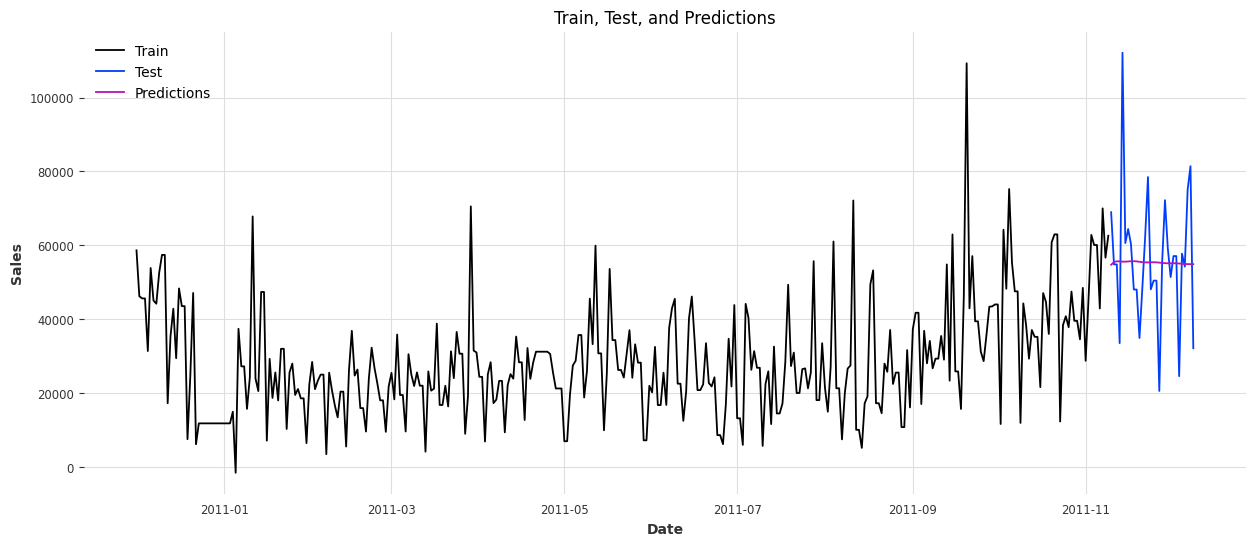

MAE,▁
MAPE,▁
RMSE,▁
MAE,12341.55023
MAPE,0.27497
RMSE,17698.44953


In [78]:
# Make predictions
rnn_predictions = rnn_forecaster.predict()

#Evaluation
rnn_eval = rnn_forecaster.evaluate(daily_sales_data[-rnn_forecaster.test_size:]['Sales'], rnn_predictions)
wandb.log(rnn_eval)
print(rnn_eval)

# Plot the train, test, pred graph
plot_train_test(daily_sales_data[:-rnn_forecaster.test_size],daily_sales_data[-rnn_forecaster.test_size:], rnn_predictions)
wandb.finish()

## Forecast

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

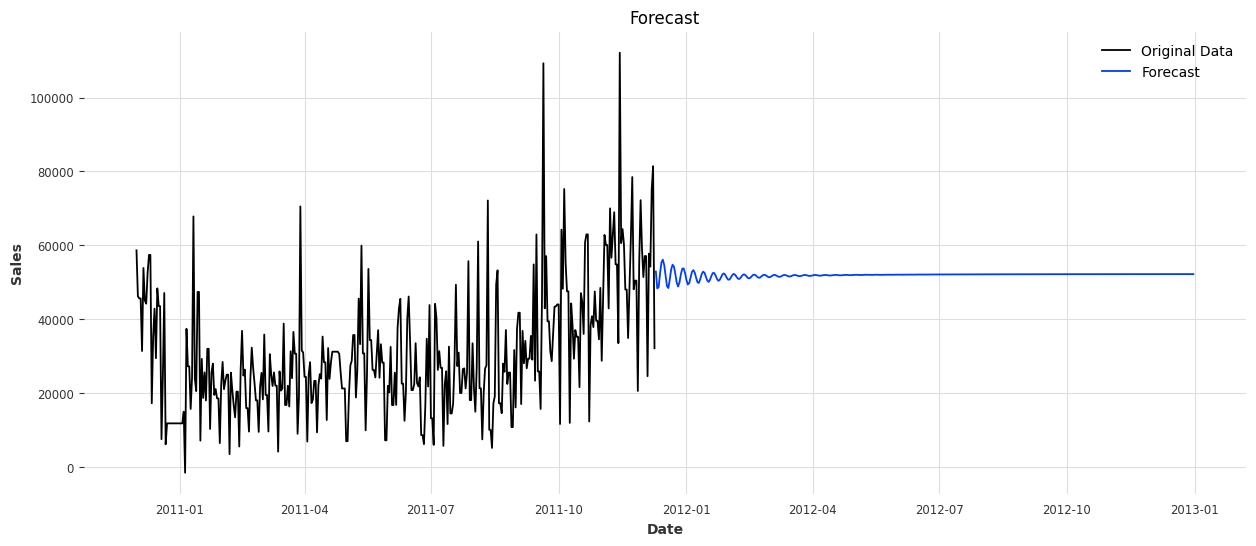

In [79]:
rnn_forecasted_values = rnn_forecaster.forecast()
plot_forecast(daily_sales_data, rnn_forecasted_values)